In [1]:
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as md
from sklearn.mixture import GaussianMixture
import yfinance as yf

# TODO: how to fix this???
import sys
sys.path.append('/Users/kasper/Documents/Stanford/Research/My papers/w_it_ewma/covariance_prediction_finance')


from cvx.covariance.trading_model import *
from cvx.covariance.utils import *
from cvx.covariance.predictors import *
from cvx.covariance.optimal_cov_pred import *

sns.set()
sns.set(font_scale=1.5)

%load_ext autoreload
%autoreload 2

# Import data

In [2]:
# Stock data
stocks = pd.read_csv('../data/sp500_test.csv', index_col=0, parse_dates=True)
stocks["mkt_cap"] = stocks.PRC * stocks.SHROUT
stocks.index = pd.to_datetime(stocks.date, format='%Y-%m-%d')
stocks = stocks.drop(columns=["date"])

# Filter on 25 largest stocks 2010-today
data_2010 = stocks.loc[stocks.index.year == 2010]
data_2010 = data_2010.drop_duplicates(subset="PERMCO", keep="first")
data_2010 = data_2010.sort_values(by="mkt_cap", ascending=False)
data_2010 = data_2010.iloc[:5,:]
SP_top50 = data_2010.PERMCO.values

data = pd.pivot_table(stocks, values='PRC', index='date', columns='PERMCO', fill_value=None)
data = data[SP_top50].loc["1990-01-01":].pct_change().dropna()

# Clip data at +- 15%
#TODO: OKAY???
data = data.clip(lower=-0.15, upper=0.15)
# Replace zeros with 1e-6 
#TODO: OKAY???
data = data.replace(0, 1e-6)

# Risk-free rate and Fama-French factors
FF = pd.read_csv('../data/ff5.csv', index_col=0, parse_dates=True)
rf_rate = pd.DataFrame(FF.loc[:,"RF"])
rf_rate.index = pd.to_datetime(rf_rate.index, format='%Y%m%d')

# Covariance predictors

In [3]:
# Rolling window predictor
rolling_window = RollingWindowPredictor(data, memory=63, update_freq=1)
rolling_window.name = "RW-63"

In [4]:
# EWMA predictor
ewma = EwmaPredictor(data, T_half=21)
ewma.name = "EWMA-21"

In [5]:
# Iterated EWMA predictor
iewma = IteratedEwmaPredictor(data, T_half_scale=10, T_half_full=21, init_cutoff=63, lamda=0)
iewma.name = "IEWMA-10-21"

In [6]:
# MGARCH predictor; precomputed in R due to computational complexity
# Note that the covariance matrices were computed for 100*r due to numerical issues 

mgarch_cond_cov = pd.read_csv("../data/SP500_5stocks_mgarch_cond_cov_5.csv", index_col=None)

Sigmas = from_row_matrix_to_covariance(mgarch_cond_cov.values, data.shape[1])

# Scale down the covariance matrices since they were computed for 100*r 
Sigmas = Sigmas/10000 

mgarch = CovariancePredictor()

# remove first year since it was used for training
mgarch.R = data.iloc[250:] 
mgarch.Sigma_hats = {mgarch.R.index[t]: Sigmas[t] for t in range(Sigmas.shape[0])}
mgarch.n = mgarch.R.shape[1]
mgarch.T = mgarch.R.shape[0]

mgarch.name = "MGARCH"

assert list(mgarch.R.index) == [*mgarch.Sigma_hats.keys()]

In [7]:
# Weighted iterated EWMA predictor
T_halfs = [(2, 5), (5, 10), (10, 21), (21, 63), (63, 125)]
const_L = "off"
turnover_cons = None
ignore_dpp = True
cm_iewma = AlternatingWeightedPredictor("iterated_ewma", data, T_halfs, likelihood_memory=10, init_cutoff=125, const_L=const_L,\
     ignore_dpp=ignore_dpp, turnover_cons=turnover_cons,\
       lamdas=[0.05, 0, 0, 0, 0])
cm_iewma.name = "CM-IEWMA"

Solving convex problem for time-varying L...


100%|██████████| 8177/8177 [04:01<00:00, 33.92it/s]


Finishing...


In [9]:
# Prescient predictor

Sigma_hats = {}
for t in data.index:
    # get sample covariance matrix for corresponding quarter
    quarter = (t.month-1)//3 + 1
    Sigma_hats[t] = np.cov(data.loc[(data.index.year == t.year) & (data.index.quarter == quarter)].values, rowvar=False)

prescient = CovariancePredictor()
prescient.R = data
prescient.Sigma_hats = Sigma_hats
prescient.n = prescient.R.shape[1]
prescient.T = prescient.R.shape[0]
prescient.name = "PRESCIENT"

assert list(prescient.R.index) == [*prescient.Sigma_hats.keys()]

# Define end and start dates for backtests

In [9]:
# Define start and end of backtest; first two years used for training/burn-in
start_date = pd.to_datetime("1990-12-28", format="%Y-%m-%d")
end_date = pd.to_datetime("2022-12-30", format="%Y-%m-%d")

# CM-IEWMA component weights

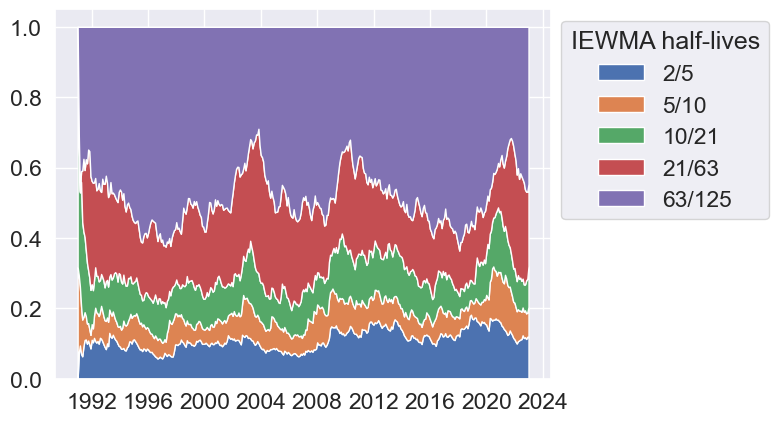

In [10]:
# plot component weights (monthly averages)
weights = cm_iewma.weights.loc[start_date:end_date].resample("M").mean().values
dates=cm_iewma.weights.loc[start_date:end_date].resample("M").mean().index
plt.stackplot(dates, get_ewmas(weights[-cm_iewma.T:], 10).T); 
plt.legend(title="IEWMA half-lives", bbox_to_anchor=(1.23, 1), loc='upper center', ncol=1, labels=[f"{T[0]}/{T[1]}"for T in T_halfs]);

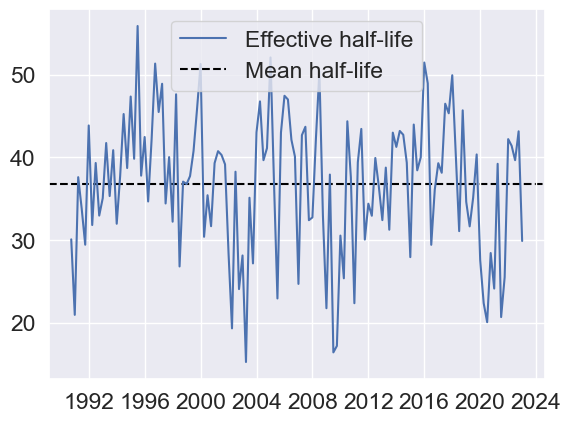

In [12]:
# plot effective half-life (quarterly averages)
T1s = np.array([T_halfs[i][0] for i in range(len(T_halfs))]).reshape(-1,1)
T2s = np.array([T_halfs[i][1] for i in range(len(T_halfs))]).reshape(-1,1)


effective_T1 = pd.DataFrame((cm_iewma.weights.values * T1s.T).sum(axis=1),\
    index=cm_iewma.weights.index, columns=["T1"])
effective_T2 = pd.DataFrame((cm_iewma.weights.values * T2s.T).sum(axis=1),\
    index=cm_iewma.weights.index, columns=["T2"])


plt.plot(effective_T1.resample("Q").mean(), label="Effective half-life");
plt.axhline(float(effective_T1.mean()), color="black", linestyle="--", label="Mean half-life", zorder=-1);
plt.legend();

# Define list of predictors and create Cholesky factors

In [13]:
# List of predictors
predictors = [rolling_window, ewma, iewma, mgarch, cm_iewma, prescient]
labels = [predictor.name for predictor in predictors]

# Get log-likelihoods and Lt_hats (Lt_hats used for some optimization problems)
for predictor in predictors:
    predictor.get_Lt_hats(start_date, end_date)
    predictor.get_log_likelihoods(start_date, end_date)

# Log-likelihood plot (quarterly averages)

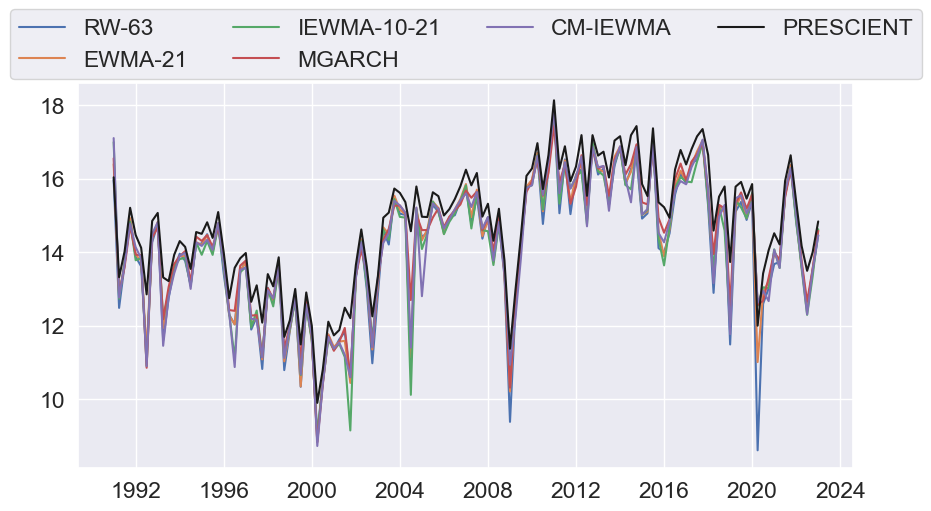

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
prescient_ind = len(predictors)-1
for i, predictor in enumerate(predictors):
    if i==prescient_ind:
        plt.plot(predictor.log_likelihoods.resample("Q").mean().index, \
        predictor.log_likelihoods.resample("Q").mean(), c="k")
    else:
        plt.plot(predictor.log_likelihoods.resample("Q").mean().index, \
        predictor.log_likelihoods.resample("Q").mean())

plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=labels, scatterpoints=1, markerscale=5);
# plt.ylim(50,95);

# Regret plot (quarterly averages)

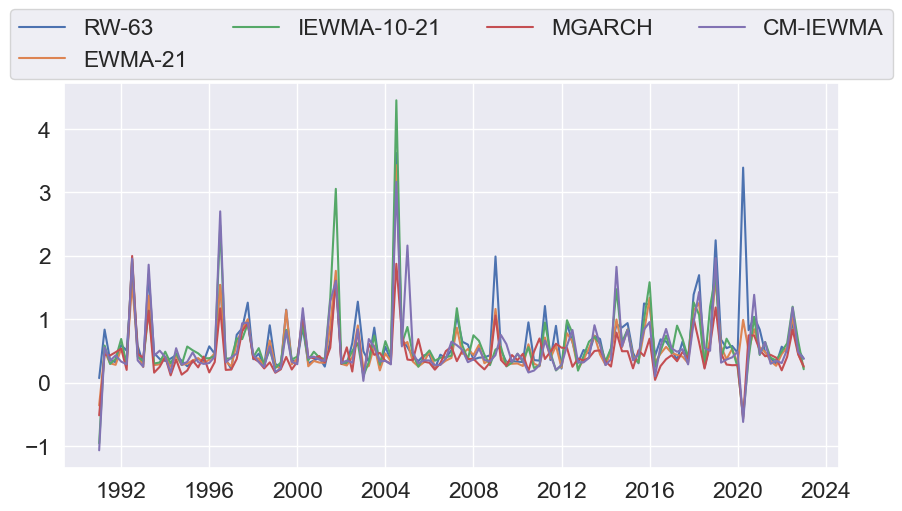

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
all_regrets = []
for i, predictor in enumerate(predictors[:-1]):
    regret =  prescient.\
        log_likelihoods.resample("Q").mean() \
            - predictor.log_likelihoods.resample("Q").mean()
            
    plt.plot(predictor.log_likelihoods.resample("Q").mean().index, regret)
    all_regrets.append(regret.values.flatten())

plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=labels, scatterpoints=1, markerscale=5);
# plt.ylim(5,75);


### Compare CM-IEWMA with MGARCH

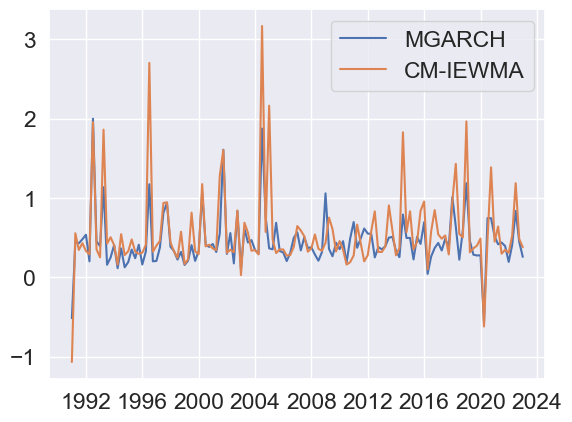

In [17]:
# Regret or W-IT-EWMA and MGARCH
regret_mgarch =  prescient.\
        log_likelihoods.resample("Q").mean() \
            - mgarch.log_likelihoods.resample("Q").mean()

plt.plot(mgarch.log_likelihoods.resample("Q").mean().index, regret_mgarch, label=mgarch.name)

regret_cm_iewma =  prescient.\
        log_likelihoods.resample("Q").mean() \
            - cm_iewma.log_likelihoods.resample("Q").mean()

plt.plot(predictor.log_likelihoods.resample("Q").mean().index, regret_cm_iewma, label=cm_iewma.name)
plt.legend();

In [18]:
cm_iewma_advantage = ((regret_cm_iewma.values - regret_mgarch.values)<0).mean()
print(f"CM-IEWMA is better than MGARCH {cm_iewma_advantage:.0%} of the time")

CM-IEWMA is better than MGARCH 37% of the time


### Regret CDF plots

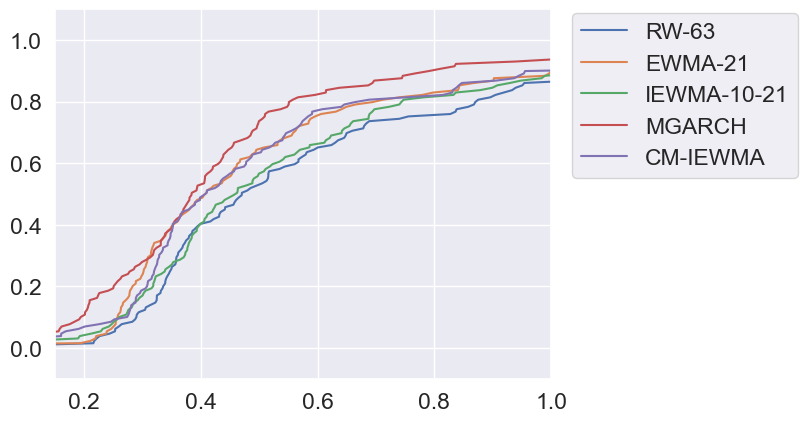

In [19]:
plot_ecdf(all_regrets, labels=labels[:-1])
plt.xlim(0.15,1)
plt.ylim(-0.1,1.1)
# put label to right of plot
plt.legend(bbox_to_anchor=(1.27, 1.02), loc='upper center', ncol=1, labels=labels[:-1]);

### Regret metrics

In [20]:
### Metrics
print("(Mean, Std, Max, 99th percentile, 95th percentile, 90th percentile)")

for i, predictor in enumerate(predictors):
    print("\n", labels[i])

    # regret =  predictors[last].log_likelihoods.resample("Q").mean() -\
    #     predictor.log_likelihoods.resample("Q").mean()
    # regret = regret.values
    
    if i < prescient_ind:
        regret = all_regrets[i]
        metrics = (np.mean(regret).round(1), np.std(regret).round(1), np.max(regret).round(1), np.quantile(regret, 0.99).round(1),\
            np.quantile(regret, 0.95).round(1), np.quantile(regret, 0.9).round(1))

        print(metrics)
    else:
        print((0.0, 0.0, 0.0, 0.0, 0.0, 0.0))

(Mean, Std, Max, 99th percentile, 95th percentile, 90th percentile)

 RW-63
(0.7, 0.5, 3.6, 3.1, 1.7, 1.2)

 EWMA-21
(0.5, 0.4, 3.4, 1.7, 1.3, 1.0)

 IEWMA-10-21
(0.6, 0.6, 4.5, 2.9, 1.4, 1.1)

 MGARCH
(0.4, 0.3, 2.0, 1.8, 1.1, 0.8)

 CM-IEWMA
(0.6, 0.5, 3.2, 2.6, 1.7, 1.0)

 PRESCIENT
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0)


# Portfolio optimization

In [26]:
# Risk-free rate for backtest period; for cash allocation
rf = rf_rate.loc[start_date:end_date]

# Portfolio constraints
additonal_cons={"short_lim":1.6, "upper_bound":0.4,\
             "lower_bound":-0.3}

### Equally weighted

In [24]:
from cvx.covariance.trading_model import *
adjust_factor = 1

traders_eq_w = []
for i in trange(len(predictors)):
    predictor = predictors[i]
    R = predictor.R.loc[start_date:end_date]
    Lt_inv_hats = {t: predictor.Lt_inv_hats[t] for t in R.index}
    Sigma_hats = {t: predictor.Sigma_hats[t] for t in R.index}
    
    trader = Trader(R=R, Lt_inv_hats=Lt_inv_hats, Sigma_hats=Sigma_hats)
    trader.ws = np.ones(trader.R.shape) / trader.n
    trader.portfolio_type = "eq_weighted"
    trader.adjust_factor = adjust_factor
    traders_eq_w.append(trader)

100%|██████████| 6/6 [00:00<00:00,  7.48it/s]


In [25]:
# Portfolio metrics
excess=False
for i, trader in enumerate(traders_eq_w):
    print("\n"+labels[i])
    trader.diluted = False
    trader.get_metrics(diluted_with_cash=True, sigma_des=0.05, rf=rf,\
        excess=excess)


RW-63
Mean annual return: 5.82%
Annual risk: 5.28%
Sharpe ratio: 1.1
Maximum drawdown: 9.41%

EWMA-21
Mean annual return: 5.77%
Annual risk: 5.14%
Sharpe ratio: 1.12
Maximum drawdown: 9.04%

IEWMA-10-21
Mean annual return: 5.94%
Annual risk: 5.19%
Sharpe ratio: 1.14
Maximum drawdown: 8.81%

MGARCH
Mean annual return: 5.59%
Annual risk: 4.86%
Sharpe ratio: 1.15
Maximum drawdown: 8.21%

CM-IEWMA
Mean annual return: 5.94%
Annual risk: 5.21%
Sharpe ratio: 1.14
Maximum drawdown: 9.41%

PRESCIENT
Mean annual return: 7.06%
Annual risk: 4.99%
Sharpe ratio: 1.41
Maximum drawdown: 8.03%


### Minimum risk

In [27]:
from cvx.covariance.trading_model import *

adjust_factor = 1

C_speedup = False # True if solving using CVXPYgen
traders_min_risk = []

for i in trange(len(predictors)):
     predictor = predictors[i]
     R = predictor.R.loc[start_date:end_date]
     Lt_inv_hats = {t: predictor.Lt_inv_hats[t] for t in R.index}
     Sigma_hats = {t: predictor.Sigma_hats[t] for t in R.index}

     trader = Trader(R=R, Lt_inv_hats=Lt_inv_hats, Sigma_hats=Sigma_hats)
     trader.backtest(adjust_factor=adjust_factor, additonal_cons=additonal_cons,\
          C_speedup=C_speedup)
     traders_min_risk.append(trader)


  0%|          | 0/6 [00:00<?, ?it/s]

Adding additional constraints


 17%|█▋        | 1/6 [00:33<02:48, 33.65s/it]

Adding additional constraints


 33%|███▎      | 2/6 [01:00<01:58, 29.70s/it]

Adding additional constraints


 50%|█████     | 3/6 [01:28<01:26, 28.74s/it]

Adding additional constraints


 67%|██████▋   | 4/6 [01:56<00:57, 28.65s/it]

Adding additional constraints


 83%|████████▎ | 5/6 [02:27<00:29, 29.53s/it]

Adding additional constraints


100%|██████████| 6/6 [03:03<00:00, 30.55s/it]


In [28]:
# Portfolio metrics
excess=False
for i, trader in enumerate(traders_min_risk):
    print("\n"+labels[i])
    trader.diluted = False
    trader.get_metrics(diluted_with_cash=True, sigma_des=0.05, rf=rf,\
        excess=excess)


RW-63
Mean annual return: 4.99%
Annual risk: 5.74%
Sharpe ratio: 0.869
Maximum drawdown: 10.85%

EWMA-21
Mean annual return: 4.76%
Annual risk: 5.56%
Sharpe ratio: 0.857
Maximum drawdown: 11.07%

IEWMA-10-21
Mean annual return: 4.66%
Annual risk: 5.82%
Sharpe ratio: 0.8
Maximum drawdown: 11.87%

MGARCH
Mean annual return: 4.54%
Annual risk: 5.07%
Sharpe ratio: 0.895
Maximum drawdown: 9.80%

CM-IEWMA
Mean annual return: 4.76%
Annual risk: 5.66%
Sharpe ratio: 0.842
Maximum drawdown: 12.02%

PRESCIENT
Mean annual return: 6.62%
Annual risk: 5.00%
Sharpe ratio: 1.33
Maximum drawdown: 8.49%


### Maximum diversification 

In [29]:
from cvx.covariance.trading_model import *

# Only additonal_cons["upper_bound"] relevant for max diverse

adjust_factor = 1

traders_max_diverse = []
for i in trange(len(predictors)):
    predictor = predictors[i]
    R = predictor.R.loc[start_date:end_date]
    Lt_inv_hats = {t: predictor.Lt_inv_hats[t] for t in R.index}
    Sigma_hats = {t: predictor.Sigma_hats[t] for t in R.index}
    
    trader = Trader(R=R, Lt_inv_hats=Lt_inv_hats, Sigma_hats=Sigma_hats)
    trader.backtest(adjust_factor=adjust_factor, additonal_cons=additonal_cons,\
         portfolio_type="max_diverse")
    traders_max_diverse.append(trader)

100%|██████████| 6/6 [00:47<00:00,  7.96s/it]


In [30]:
# Portfolio metrics
excess=False
for i, trader in enumerate(traders_max_diverse):
    print("\n"+labels[i])
    trader.diluted = False
    trader.get_metrics(diluted_with_cash=True, sigma_des=0.05, rf=rf,\
        excess=excess)


RW-63
Mean annual return: 5.84%
Annual risk: 5.59%
Sharpe ratio: 1.05
Maximum drawdown: 9.64%

EWMA-21
Mean annual return: 5.64%
Annual risk: 5.39%
Sharpe ratio: 1.05
Maximum drawdown: 9.26%

IEWMA-10-21
Mean annual return: 5.79%
Annual risk: 5.54%
Sharpe ratio: 1.05
Maximum drawdown: 9.39%

MGARCH
Mean annual return: 5.37%
Annual risk: 4.95%
Sharpe ratio: 1.08
Maximum drawdown: 8.58%

CM-IEWMA
Mean annual return: 5.66%
Annual risk: 5.47%
Sharpe ratio: 1.04
Maximum drawdown: 10.33%

PRESCIENT
Mean annual return: 7.02%
Annual risk: 5.00%
Sharpe ratio: 1.41
Maximum drawdown: 7.58%


### Risk parity 

In [31]:
from cvx.covariance.trading_model import *
adjust_factor = 1
    
traders_risk_par = []
for i in trange(len(predictors)):
    predictor = predictors[i]
    R = predictor.R.loc[start_date:end_date]
    Lt_inv_hats = {t: predictor.Lt_inv_hats[t] for t in R.index}
    Sigma_hats = {t: predictor.Sigma_hats[t] for t in R.index}
    
    trader = Trader(R=R, Lt_inv_hats=Lt_inv_hats, Sigma_hats=Sigma_hats)
    trader.backtest(adjust_factor=adjust_factor, portfolio_type="risk_parity")
    traders_risk_par.append(trader)

100%|██████████| 6/6 [02:52<00:00, 28.82s/it]


In [32]:
# Portfolio metrics
excess=False
for i, trader in enumerate(traders_risk_par):
    print("\n"+labels[i])
    trader.diluted = False
    trader.get_metrics(diluted_with_cash=True, sigma_des=0.05, rf=rf,\
        excess=excess)


RW-63
Mean annual return: 5.64%
Annual risk: 5.47%
Sharpe ratio: 1.03
Maximum drawdown: 10.00%

EWMA-21
Mean annual return: 5.46%
Annual risk: 5.29%
Sharpe ratio: 1.03
Maximum drawdown: 9.77%

IEWMA-10-21
Mean annual return: 5.56%
Annual risk: 5.44%
Sharpe ratio: 1.02
Maximum drawdown: 9.70%

MGARCH
Mean annual return: 5.25%
Annual risk: 4.93%
Sharpe ratio: 1.06
Maximum drawdown: 8.83%

CM-IEWMA
Mean annual return: 5.56%
Annual risk: 5.37%
Sharpe ratio: 1.03
Maximum drawdown: 10.41%

PRESCIENT
Mean annual return: 7.04%
Annual risk: 4.99%
Sharpe ratio: 1.41
Maximum drawdown: 7.38%


### Maximum Sharp ratio

In [217]:
from cvx.covariance.trading_model import *
    
# EWMA returns
# r_ewma = get_ewmas(data.values, T_half=1)
# r_hat_ewma = pd.DataFrame(r_ewma[:-1], index=data.index[1:],\
#      columns=data.columns)

# previous day's returns
r_hats = pd.DataFrame(data.iloc[:-1].values, index=data.index[1:],\
     columns=data.columns)
r_hats = r_hats.loc[start_date:end_date]

traders_max_sharpe = []
for i in trange(len(predictors)):
    predictor = predictors[i]
    R = predictor.R.loc[start_date:end_date]
    Lt_inv_hats = {t: predictor.Lt_inv_hats[t] for t in R.index}
    Sigma_hats = {t: predictor.Sigma_hats[t] for t in R.index}
    
    trader = Trader(R=R, Lt_inv_hats=Lt_inv_hats, Sigma_hats=Sigma_hats,\
    r_hats=r_hats)
    trader.backtest(adjust_factor=adjust_factor, additonal_cons=additonal_cons,\
        portfolio_type="mean_variance", sigma_des=0.05)
    traders_max_sharpe.append(trader)

100%|██████████| 6/6 [02:31<00:00, 25.20s/it]


In [218]:
# Portfolio metrics
excess=False
for i, trader in enumerate(traders_max_sharpe):
    print("\n"+labels[i])
    trader.get_metrics(diluted_with_cash=False, rf=rf,\
        excess=excess)


RW-250
Mean annual return: -1.30%
Annual risk: 7.15%
Sharpe ratio: -0.182
Maximum drawdown: 41.24%

EWMA-125
Mean annual return: -1.24%
Annual risk: 6.27%
Sharpe ratio: -0.198
Maximum drawdown: 39.27%

IEWMA-63-125
Mean annual return: -0.31%
Annual risk: 6.17%
Sharpe ratio: -0.0503
Maximum drawdown: 34.79%

MGARCH
Mean annual return: -2.01%
Annual risk: 6.04%
Sharpe ratio: -0.333
Maximum drawdown: 39.60%

CM-IEWMA
Mean annual return: -0.55%
Annual risk: 6.10%
Sharpe ratio: -0.0898
Maximum drawdown: 36.12%

PRESCIENT
Mean annual return: -1.01%
Annual risk: 4.64%
Sharpe ratio: -0.219
Maximum drawdown: 33.92%
